In [ ]:
import numpy as np
import pickle
import joblib
import pandas as pd
import sys
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Flatten, Input, TimeDistributed, BatchNormalization, GRU
from sklearn.metrics import confusion_matrix
import seaborn as sns
import os
from keras.models import load_model
from keras.callbacks import Callback
import json
import io

In [ ]:
# instalar comet ml en caso que sea necesario
!pip install comet_ml
from comet_ml import Experiment

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 723.1/723.1 kB 24.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 36.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 48.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.8/144.8 kB 10.7 MB/s eta 0:00:00
  Attempting uninstall: python-box
    Found existing installation: python-box 7.3.2
    Uninstalling python-box-7.3.2:
      Successfully uninstalled python-box-7.3.2


In [ ]:
# establecer semilla
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

# Levanto datos crudos por sujeto

In [ ]:
# Directorio de los datos
%cd "/content/drive/My Drive/repo_tesis/src/ronda_experimentos_2/datos_crudos2feature_dataset"

/content/drive/.shortcut-targets-by-id/1p7dFFKqLvO4o4GAmIQpnbXVWvt_2Dv-l/repo_tesis/src/ronda_experimentos_2/datos_crudos2feature_dataset


In [ ]:
# levanto todos los datasets
cant_ds = 10
list_ds = []
for i in range(cant_ds):
  # ds = tf.data.Dataset.load("dataset_E1_selected_con_reposo_feature_sub"+str(i)+"_seq_seq")
  # ds = tf.data.Dataset.load("2025_dataset_E1_con_reposo_features_sub"+str(i)) # feature con reposo
  ds = tf.data.Dataset.load("2025_dataset_E1_sin_reposo_feature_sub"+str(i))
  list_ds.append(ds)

## Usando partición 1
Recordar que los sujetos de test son el 1 y el 7 (empezando desde el 0).

Voy a tomar para validar los sujetos 2 y 8

In [ ]:
def generar_particion1(list_ds):
  # Esta funcion recibe como entrada una lista con los folds, donde cada fold es un dataset,
  # y devuelve un conjunto de train, val y test:
  # test: fold 1 y 7, val: 2 y 8, train: resto.

  # Armo el conjunto de test
  ds_test = list_ds[1]
  # lo concateno con el 7
  ds_test = ds_test.concatenate(list_ds[7])

  # Armo el conjunto de validacion
  ds_val = list_ds[2]
  # lo concateno con el 8
  ds_val = ds_val.concatenate(list_ds[8])

  # Armo el conjunto de train
  ind_train = list(np.arange(10))
  ind_train.pop(1)
  ind_train.pop(6)

  # elimino los de val
  ind_train.pop(1)
  ind_train.pop(5)

  ind_train.pop(0)  # porque inicializo el dataset con este
  ds_train = list_ds[0]
  for i in ind_train:
    ds_train = ds_train.concatenate(list_ds[i])

  return ds_train, ds_val, ds_test

ds_train_base, ds_val_base, ds_test_base = generar_particion1(list_ds)  # le agrego base para poder usarlos al final sin modificaciones

# Levanto los datos crudos seq to seq

## Por repetición

In [ ]:
# Directorio de los datos
%cd "/content/drive/My Drive/repo_tesis/src/ronda_experimentos_2/datos_crudos2dataset_x_rep"

/content/drive/.shortcut-targets-by-id/1p7dFFKqLvO4o4GAmIQpnbXVWvt_2Dv-l/repo_tesis/src/ronda_experimentos_2/datos_crudos2dataset_x_rep


In [ ]:
# levanto todos los datasets
cant_ds = 10  # esta es la cantidad de sujetos
cant_rep = 6
list_ds = []
for i in range(cant_ds):
  ds_reps = []
  for j in range(cant_rep):
    ds_reps_j = tf.data.Dataset.load("dataset_E1_selected_sin_reposo_crudo_sub"+str(i)+"x_rep_fold_rep_"+str(j))
    ds_reps.append(ds_reps_j)
  list_ds.append(ds_reps)

Primero tengo que unir los 6 folds de cada sujeto para armar los que son por repeticion.
En cada elemento de list_ds tengo 6 folds, de las diferentes repeticiones. Quiero unirlos.

In [ ]:
folds_rep = [[], [], [], [], [], []]

for i in list_ds:
  for j in range(len(i)):
    folds_rep[j].append(i[j])

In [ ]:
# por ahora lo hago hardcodeado para cada fold
fold0_rep = folds_rep[0]
fold1_rep = folds_rep[1]
fold2_rep = folds_rep[2]
fold3_rep = folds_rep[3]
fold4_rep = folds_rep[4]
fold5_rep = folds_rep[5]

# fold 0
ds_test_base = fold0_rep[0]
for i in range(1, len(fold0_rep)):
  ds_test_base = ds_test_base.concatenate(fold0_rep[i])

# fold 1
ds_val_base = fold1_rep[0]
for i in range(1, len(fold1_rep)):
  ds_val_base = ds_val_base.concatenate(fold1_rep[i])

# fold 2
ds2_all = fold2_rep[0]
for i in range(1, len(fold2_rep)):
  ds2_all = ds2_all.concatenate(fold2_rep[i])

# fold 3
ds3_all = fold3_rep[0]
for i in range(1, len(fold3_rep)):
  ds3_all = ds3_all.concatenate(fold3_rep[i])

# fold 4
ds4_all = fold4_rep[0]
for i in range(1, len(fold4_rep)):
  ds4_all = ds4_all.concatenate(fold4_rep[i])

# fold 5
ds5_all = fold5_rep[0]
for i in range(1, len(fold5_rep)):
  ds5_all = ds5_all.concatenate(fold5_rep[i])

Voy a usar el 0 para test, el 1 para val y uno el resto para el train.

In [ ]:
ds2_all = ds2_all.concatenate(ds3_all)
ds2_all = ds2_all.concatenate(ds4_all)

# lo llamo ds_train
ds_train_base = ds2_all.concatenate(ds5_all)


Creo un directorio para guardar los modelos y otras cosas relativos al entrenamiento de este modelo.

# Preparación de datos

In [ ]:
# elijo el directorio donde quiero guardar los resultados del experimento actual
nombre_exp = "ronda3_RNN_E1_feature_sin_reposo_100%_61_stride1_x_sujeto_seq_seq"
ruta_experimento = "/content/drive/My Drive/repo_tesis/src/ronda_experimentos_3/modelos/" + nombre_exp
os.makedirs(ruta_experimento, exist_ok=True) # me fijo si existe, si no, lo creo
# os.chdir(ruta_experimento) # me situo en el directorio

In [ ]:
for x, y in ds_train_base.take(1):
  input_shape = x.shape
  label_shape = y.shape
  label = y
print('Input shape:', input_shape)
print('Label shape:', label_shape)
print('Label', label)
# num_classes = 23
num_classes = 12

Input shape: (61, 240)
Label shape: (61,)
Label tf.Tensor(
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0], shape=(61,), dtype=int64)


In [ ]:
# Función para convertir etiquetas a formato one-hot
def one_hot_encode(features, label):
    label = tf.one_hot(label, depth=num_classes)
    return features, label

In [ ]:
# funciones de acondicionamiento de los datos
BATCH_SIZE = 16
def preparar_ds(ds):
  ds = ds.map(one_hot_encode) # paso las clases a una codificacion one hot
  ds = ds.shuffle(buffer_size=ds.cardinality()) # hago un shuffle de los datos
  ds = ds.batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE) # armo batches y cargo en memoria la cantidad de datos optima, listos para ser utilizados
  return ds

ds_train = preparar_ds(ds_train_base)
ds_val = preparar_ds(ds_val_base)
ds_test = preparar_ds(ds_test_base)

# Diseño e implementación de RNN

In [ ]:
# Definir la entrada
input_shape = (61, 240)  # Input shape es (BATCH_SIZE, largo_secuencia, dim_datos), pero la batch size no se incluye en input_shape

# Crear un modelo secuencial
model = Sequential()

# Agregar la primera capa LSTM
# model.add(GRU(48, return_sequences=True, input_shape=input_shape))
# model.add(BatchNormalization())
model.add(LSTM(48, return_sequences=True, input_shape=input_shape))
# model.add(LSTM(128, return_sequences=True, input_shape=input_shape))
# model.add(BatchNormalization())
# # Capa de salida TimeDistributed
# model.add(TimeDistributed(Dense(64, activation='relu')))
# # Capa de salida TimeDistributed
model.add((Dense(num_classes, activation='softmax')))

# defino el learning rate
lr = 0.00005

# Compilar el modelo
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), loss='categorical_crossentropy', metrics=['accuracy'])

# Resumen del modelo
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 61, 48)              │          55,488 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 61, 12)              │             588 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 56,076 (219.05 KB)

 Trainable params: 56,076 (219.05 KB)

 Non-trainable params: 0 (0.00 B)

## Si entreno el modelo por primera vez

In [ ]:
class CustomSaver(Callback):
    def __init__(self, model_save_path, history_save_path, initial_epoch=0):
        super(CustomSaver, self).__init__()
        self.model_save_path = model_save_path
        self.history_save_path = history_save_path
        self.epoch_offset = initial_epoch
        self.history = []

    def on_epoch_end(self, epoch, logs=None):
        # Guardar el modelo
        model_file = os.path.join(self.model_save_path, f'model_epoch_{self.epoch_offset + epoch + 1}.keras')
        self.model.save(model_file)
        print(f'Modelo guardado en {model_file}')

        # Acumular y guardar la historia de entrenamiento
        self.history.append(logs)
        history_file = os.path.join(self.history_save_path, 'complete_history.json')
        with open(history_file, 'w') as f:
            json.dump(self.history, f)
        print(f'Historia de entrenamiento guardada en {history_file}')

# Crear el callback
saver = CustomSaver(model_save_path=ruta_experimento, history_save_path=ruta_experimento)

# Entrenar el modelo
history = model.fit(ds_train, validation_data=ds_val, epochs=10, callbacks=[saver])

Epoch 1/10
721/726 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.2034 - loss: 2.1780Modelo guardado en /content/drive/My Drive/repo_tesis/src/ronda_experimentos_3/modelos/ronda3_RNN_E1_feature_sin_reposo_100%_61_stride1_x_sujeto_seq_seq/model_epoch_1.keras
Historia de entrenamiento guardada en /content/drive/My Drive/repo_tesis/src/ronda_experimentos_3/modelos/ronda3_RNN_E1_feature_sin_reposo_100%_61_stride1_x_sujeto_seq_seq/complete_history.json
726/726 ━━━━━━━━━━━━━━━━━━━━ 66s 34ms/step - accuracy: 0.2042 - loss: 2.1762 - val_accuracy: 0.3014 - val_loss: 1.8470
Epoch 2/10
726/726 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.4608 - loss: 1.5210Modelo guardado en /content/drive/My Drive/repo_tesis/src/ronda_experimentos_3/modelos/ronda3_RNN_E1_feature_sin_reposo_100%_61_stride1_x_sujeto_seq_seq/model_epoch_2.keras
Historia de entrenamiento guardada en /content/drive/My Drive/repo_tesis/src/ronda_experimentos_3/modelos/ronda3_RNN_E1_feature_sin_reposo_100%_61_stride1_x_sujeto_seq_s

<Axes: xlabel='Epoch'>

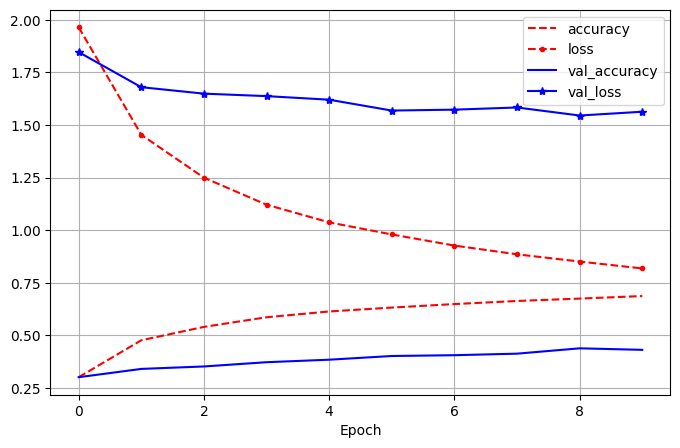

In [ ]:
# Visualizacion de la evolucion del entrenamiento
pd.DataFrame(history.history).plot(
figsize=(8, 5), grid=True, xlabel="Epoch",  # xlim=[0, 10], ylim=[0, 1],
style=["r--", "r--.", "b-", "b-*"])
# plt.savefig("evolucion_entrenamiento.png")

## Si quiero retomar el entrenamiento

In [ ]:
class CustomSaver(Callback):
    def __init__(self, model_save_path, history_save_path, initial_epoch=0):
        super(CustomSaver, self).__init__()
        self.model_save_path = model_save_path
        self.history_save_path = history_save_path
        self.epoch_offset = initial_epoch
        self.history = []

    def on_epoch_end(self, epoch, logs=None):
        # Guardar el modelo
        model_file = os.path.join(self.model_save_path, f'model_epoch_{epoch + 1}.keras') # self.epoch_offset +
        self.model.save(model_file)
        print(f'Modelo guardado en {model_file}')

        # Acumular y guardar la historia de entrenamiento
        self.history.append(logs)
        history_file = os.path.join(self.history_save_path, 'complete_history.json')
        with open(history_file, 'w') as f:
            json.dump(self.history, f)
        print(f'Historia de entrenamiento guardada en {history_file}')

# Cargar el modelo guardado en la época 3
model = load_model(os.path.join(ruta_experimento, 'model_epoch_10.keras'))

# Cargar la historia de entrenamiento completa
history_file = os.path.join(ruta_experimento, 'complete_history.json')
if os.path.exists(history_file):
    with open(history_file, 'r') as f:
        complete_history = json.load(f)
else:
    complete_history = []

# Crear el callback personalizado para continuar guardando modelos y la historia
saver = CustomSaver(model_save_path=ruta_experimento, history_save_path=ruta_experimento, initial_epoch=len(complete_history))

# Cargar la historia acumulada en el callback
saver.history = complete_history

# AJUSTAR LA EPOCA EN LA QUE RETOMO EL ENTRENAMIENTO
# Continuar el entrenamiento desde la última época. En initial_epoch pongo el numero de la ultima epoca entrenada
model.fit(ds_train, validation_data=ds_val, epochs=15, initial_epoch=10, callbacks=[saver])

Epoch 11/15
723/726 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.6929 - loss: 0.7918Modelo guardado en /content/drive/My Drive/repo_tesis/src/ronda_experimentos_3/modelos/ronda3_RNN_E1_feature_sin_reposo_100%_61_stride1_x_sujeto_seq_seq/model_epoch_11.keras
Historia de entrenamiento guardada en /content/drive/My Drive/repo_tesis/src/ronda_experimentos_3/modelos/ronda3_RNN_E1_feature_sin_reposo_100%_61_stride1_x_sujeto_seq_seq/complete_history.json
726/726 ━━━━━━━━━━━━━━━━━━━━ 20s 18ms/step - accuracy: 0.6929 - loss: 0.7918 - val_accuracy: 0.4406 - val_loss: 1.5859
Epoch 12/15
725/726 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6933 - loss: 0.7784Modelo guardado en /content/drive/My Drive/repo_tesis/src/ronda_experimentos_3/modelos/ronda3_RNN_E1_feature_sin_reposo_100%_61_stride1_x_sujeto_seq_seq/model_epoch_12.keras
Historia de entrenamiento guardada en /content/drive/My Drive/repo_tesis/src/ronda_experimentos_3/modelos/ronda3_RNN_E1_feature_sin_reposo_100%_61_stride1_x_sujeto_s

## Si el modelo está entrenado

In [ ]:
class CustomSaver(Callback):
    def __init__(self, model_save_path, history_save_path, initial_epoch=0):
        super(CustomSaver, self).__init__()
        self.model_save_path = model_save_path
        self.history_save_path = history_save_path
        self.epoch_offset = initial_epoch
        self.history = []

    def on_epoch_end(self, epoch, logs=None):
        # Guardar el modelo
        model_file = os.path.join(self.model_save_path, f'model_epoch_{epoch + 1}.keras') # self.epoch_offset +
        self.model.save(model_file)
        print(f'Modelo guardado en {model_file}')

        # Acumular y guardar la historia de entrenamiento
        self.history.append(logs)
        history_file = os.path.join(self.history_save_path, 'complete_history.json')
        with open(history_file, 'w') as f:
            json.dump(self.history, f)
        print(f'Historia de entrenamiento guardada en {history_file}')

# ELIJO QUE EPOCA QUIERO USAR, PUEDO MIRAR LA GRAFICA Y ELEGIR LA MEJOR
# Cargar el modelo guardado en la época 3
model = load_model(os.path.join(ruta_experimento, 'model_epoch_9.keras'))

# Cargar la historia de entrenamiento completa
history_file = os.path.join(ruta_experimento, 'complete_history.json')
if os.path.exists(history_file):
    with open(history_file, 'r') as f:
        complete_history = json.load(f)
else:
    complete_history = []

# Crear el callback personalizado para continuar guardando modelos y la historia
saver = CustomSaver(model_save_path=ruta_experimento, history_save_path=ruta_experimento, initial_epoch=len(complete_history))

# Cargar la historia acumulada en el callback
saver.history = complete_history

<Axes: xlabel='Epoch'>

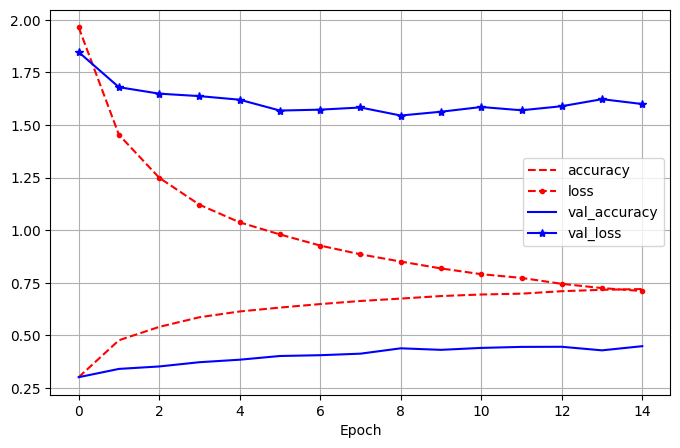

In [ ]:
# Visualizacion de la evolucion del entrenamiento
pd.DataFrame(complete_history).plot(
figsize=(8, 5), grid=True, xlabel="Epoch",  # xlim=[0, 10], ylim=[0, 1],
style=["r--", "r--.", "b-", "b-*"])
# plt.savefig("evolucion_entrenamiento.png")

# Adaptación para hacer los evaluate
Para ejecutar esta parte tengo que tener el modelo entrenado y los dataset base cargados en memoria. Si el modelo ya está entrenado tengo que ejecutar la celda correspondiente.

## Cálculo de predicciones

In [ ]:
# armo batches en los conjuntos para poder realizar predicciones
ds_train_batch = ds_train_base.batch(16)
ds_val_batch = ds_val_base.batch(16)
ds_test_batch = ds_test_base.batch(16)

In [ ]:
# Obtener las predicciones en 1hot
y_pred_train_1hot = model.predict(ds_train_batch)
y_pred_val_1hot = model.predict(ds_val_batch)
y_pred_test_1hot = model.predict(ds_test_batch)

726/726 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step
183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step
241/241 ━━━━━━━━━━━━━━━━━━━━ 18s 70ms/step


Se puede ver que las predicciones no quedaron organizadas en batches, pero sí devuelven un vector codificado en one hot.

In [ ]:
def onehot2numerical(y_pred):
  # Convertir de one-hot a clases numéricas las predicciones
  y_clases = tf.argmax(y_pred, axis=-1)
  # Convertir a numpy si es necesario
  y_clases_numpy = y_clases.numpy()
  return y_clases_numpy

y_pred_train = onehot2numerical(y_pred_train_1hot)
y_pred_val = onehot2numerical(y_pred_val_1hot)
y_pred_test = onehot2numerical(y_pred_test_1hot)

## Extracción de etiquetas reales

In [ ]:
def extraer_etiquetas_ds(ds):
  y_train_true_list = []
  for x, y in ds: # dataset_with_classes ds_train
    # print(y.shape)
    y_train_true_list.append(y.numpy())
  return y_train_true_list

y_true_train_list = extraer_etiquetas_ds(ds_train_base)
y_true_val_list = extraer_etiquetas_ds(ds_val_base)
y_true_test_list = extraer_etiquetas_ds(ds_test_base)

In [ ]:
y_true_train_array = np.array(y_true_train_list)
y_true_val_array = np.array(y_true_val_list)
y_true_test_array = np.array(y_true_test_list)

print(y_true_train_array.shape)

(11612, 61)


In [ ]:
# Visualizacion de ejemplo
y_true_train_list[2]

# Cálculo etiquetas mas probables
Cada secuencia real, contiene la misma clase en todos sus instantes por como fue armado el dataset. Sin embargo, esto no sucede en las secuencias predichas.

Para cada secuencia voy a armar un ranking de las 3 etiquetas que más aparecen en cada secuencia. Obviamente voy a considerar en primer lugar la más abundante, pero para los casos que clasifique mal, me puedo fijar si la etiqueta se encuentra en el segundo o tercer lugar.

Por otra parte, esto me puede llegar a devolver un índice de confiabilidad de la predicción, lo cual es útil si pensara en ir a un sistema de voting.

In [ ]:
def calculo_ranking_predicciones(y_true, y_pred): # esto quizas se puede hacer mejor luego

  # Me fijo los tres valores mas frecuentes en cada prediccion
  predicciones_rank3 = []
  porcion_predicciones = []
  predicciones_rank1 = []
  etiqueta_vector = []

  for i in range(len(y_true)):
    unique_values, counts = np.unique(y_pred[i], return_counts=True)
    # Ordena los índices de `counts` de mayor a menor
    sorted_indices = np.argsort(-counts)

    # Aplica estos índices para ordenar `unique_values` y `counts`
    sorted_unique_values = unique_values[sorted_indices]
    sorted_counts = counts[sorted_indices]
    # print(unique_values)
    if len(unique_values) >= 3:
      predicciones_rank3.append(sorted_unique_values[:3])
      porcion_predicciones.append(sorted_counts[:3]/650) # porque 650 es el largo de la secuencia
    else:
      predicciones_rank3.append(sorted_unique_values)
      porcion_predicciones.append(sorted_counts/650) # porque 650 es el largo de la secuencia

    # rank1 de predicciones
    predicciones_rank1.append(sorted_unique_values[0])

    # me fijo la etiqueta más presente en la secuencia real
    unique_values, counts = np.unique(y_true[i], return_counts=True)
    # Ordena los índices de `counts` de mayor a menor
    sorted_indices = np.argsort(-counts)

    # Aplica estos índices para ordenar `unique_values` y `counts`
    sorted_unique_values = unique_values[sorted_indices]
    # etiquetas reales
    etiqueta_vector.append(sorted_unique_values[0])  # me fijo en el primer valor porque son todos iguales

  return predicciones_rank3, porcion_predicciones, predicciones_rank1, etiqueta_vector

# train
predicciones_rank3_train, porcion_predicciones_train, predicciones_rank1_train, etiqueta_vector_train = calculo_ranking_predicciones(y_true_train_list, y_pred_train)

# val
predicciones_rank3_val, porcion_predicciones_val, predicciones_rank1_val, etiqueta_vector_val = calculo_ranking_predicciones(y_true_val_list, y_pred_val)

# test
predicciones_rank3_test, porcion_predicciones_test, predicciones_rank1_test, etiqueta_vector_test = calculo_ranking_predicciones(y_true_test_list, y_pred_test)

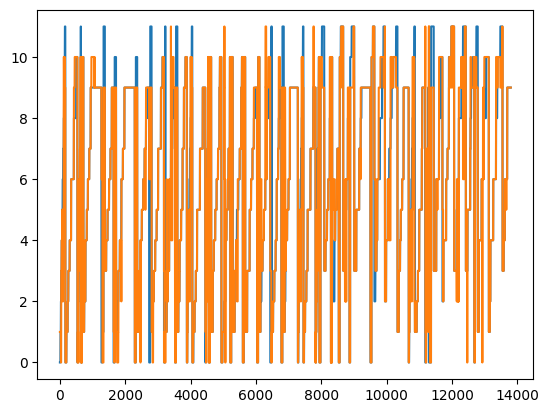

In [ ]:
# Visualización rápida: etiquetas vs prediccion rank1
plt.figure()
plt.plot(etiqueta_vector_train)
plt.plot(predicciones_rank1_train)

# Cálculo de métricas y corrección de datos

0.7867723045125732 0.4890335846470185 0.5446058091286307


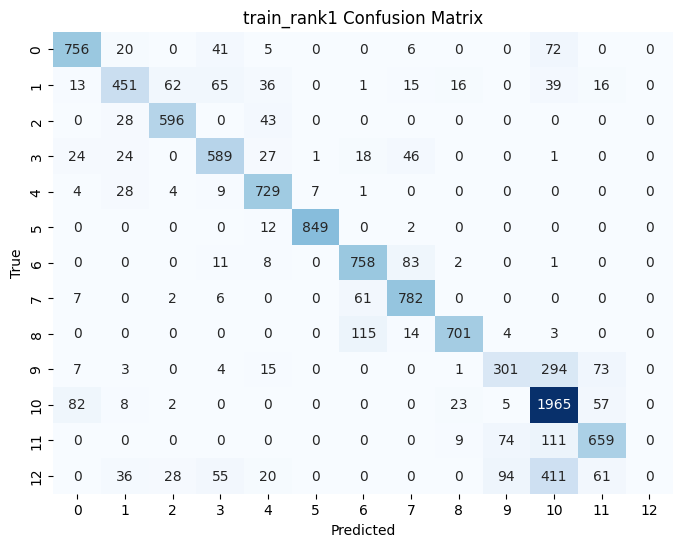

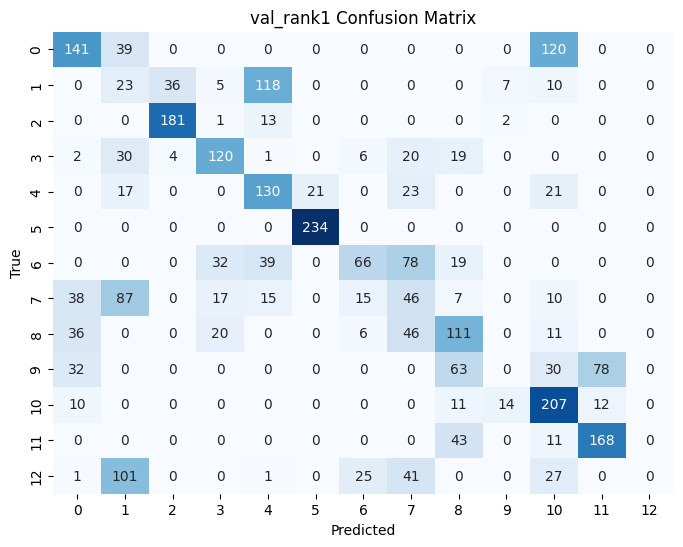

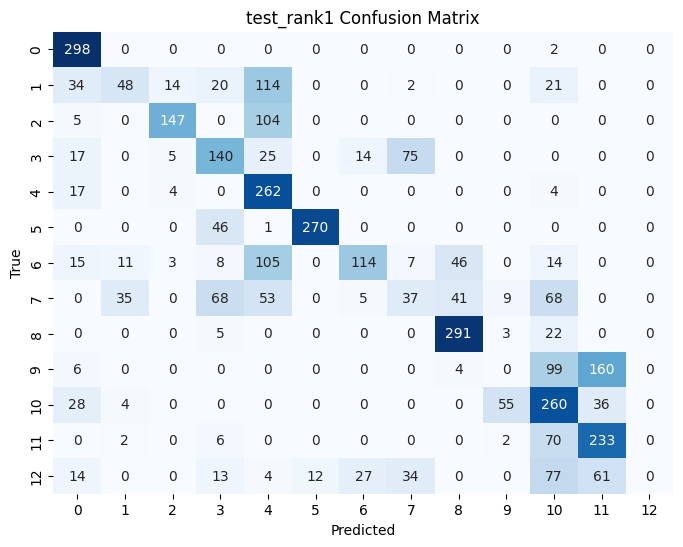

In [ ]:
def calcular_porcion_correcta(y_true, y_pred, name):
  y_true = np.array(y_true)
  y_pred = np.array(y_pred)

  indices_correcto = np.where(y_true==y_pred)[0]
  indices_no_correcto = np.where(y_true!=y_pred)[0]

  # print(len(indices_correcto)/len(y_true))

  # Calcular la matriz de confusión
  cm = confusion_matrix(y_true, y_pred)

  # Crear un gráfico de la matriz de confusión
  plt.figure(figsize=(8, 6))
  sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
  plt.xlabel("Predicted")
  plt.ylabel("True")
  plt.title(name + " Confusion Matrix")
  plt.savefig(name + "_matrix.png")
  return indices_correcto, indices_no_correcto

# train
indices_correcto_train, indices_no_correcto_train = calcular_porcion_correcta(etiqueta_vector_train, predicciones_rank1_train, 'train_rank1')

# val
indices_correcto_val, indices_no_correcto_val = calcular_porcion_correcta(etiqueta_vector_val, predicciones_rank1_val, 'val_rank1')

# test
indices_correcto_test, indices_no_correcto_test = calcular_porcion_correcta(etiqueta_vector_test, predicciones_rank1_test, 'test_rank1')

accuracy_train_rank1 = len(indices_correcto_train)/len(etiqueta_vector_train)
accuracy_val_rank1 = len(indices_correcto_val)/len(etiqueta_vector_val)
accuracy_test_rank1 = len(indices_correcto_test)/len(etiqueta_vector_test)

print(accuracy_train_rank1, accuracy_val_rank1, accuracy_test_rank1)

In [ ]:
np.unique(etiqueta_vector_train)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11], dtype=int32)

In [ ]:
def sustituir_rank2(indices_no_correcto,predicciones_rank3, predicciones_rank1):

  # me fijo en los que clasifiqué mal, y le asigno el segundo en el ranking
  predicciones_rank2 = predicciones_rank1.copy()
  # predicciones_rank2_train[indices_no_correcto_train] =
  for i in indices_no_correcto:
    if len(predicciones_rank3[i])>1:
      predicciones_rank2[i] = predicciones_rank3[i][1]

  return predicciones_rank2

predicciones_rank2_train = sustituir_rank2(indices_no_correcto_train, predicciones_rank3_train, predicciones_rank1_train)
predicciones_rank2_val = sustituir_rank2(indices_no_correcto_val, predicciones_rank3_val, predicciones_rank1_val)
predicciones_rank2_test = sustituir_rank2(indices_no_correcto_test, predicciones_rank3_test, predicciones_rank1_test)

0.8752152945229074 0.5962988348183688 0.6545643153526971


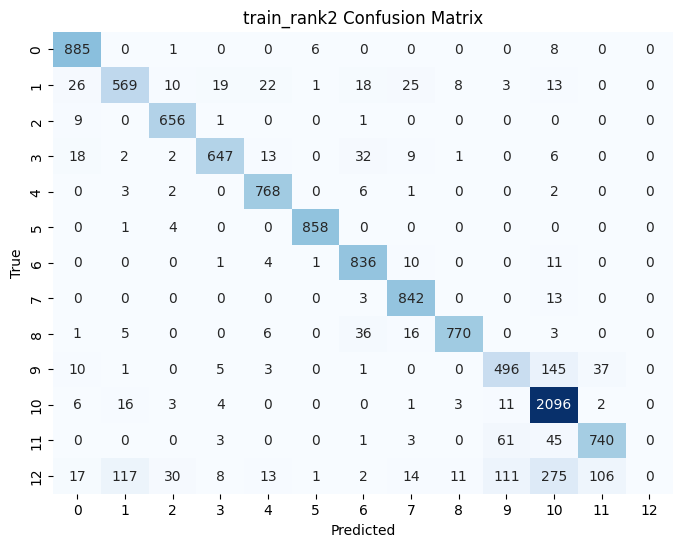

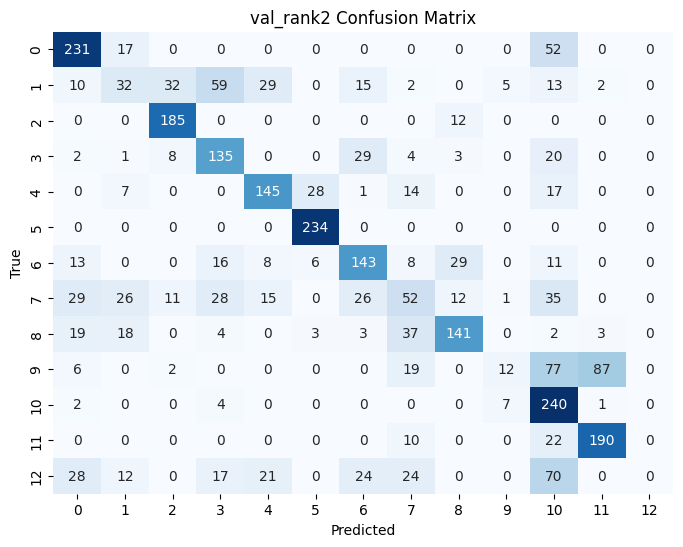

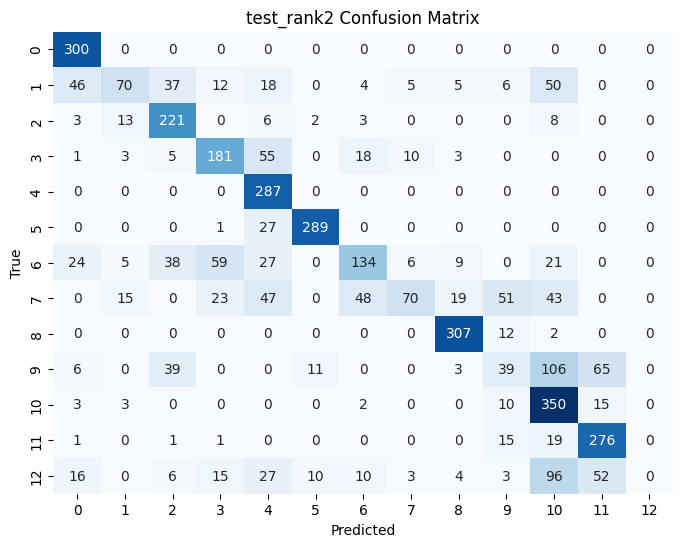

In [ ]:
# train
indices_correcto_train, indices_no_correcto_train = calcular_porcion_correcta(etiqueta_vector_train, predicciones_rank2_train, 'train_rank2')

# val
indices_correcto_val, indices_no_correcto_val = calcular_porcion_correcta(etiqueta_vector_val, predicciones_rank2_val, 'val_rank2')

# test
indices_correcto_test, indices_no_correcto_test = calcular_porcion_correcta(etiqueta_vector_test, predicciones_rank2_test, 'test_rank2')

accuracy_train_rank2 = len(indices_correcto_train)/len(etiqueta_vector_train)
accuracy_val_rank2 = len(indices_correcto_val)/len(etiqueta_vector_val)
accuracy_test_rank2 = len(indices_correcto_test)/len(etiqueta_vector_test)

print(accuracy_train_rank2, accuracy_val_rank2, accuracy_test_rank2)

In [ ]:
def sustituir_rank3(indices_no_correcto,predicciones_rank3, predicciones_rank2):

  # me fijo en los que clasifiqué mal, y le asigno el segundo en el ranking
  predicciones_rank3_unica = predicciones_rank2.copy()
  # predicciones_rank2_train[indices_no_correcto_train] =
  for i in indices_no_correcto:
    if len(predicciones_rank3[i])>2:
      predicciones_rank3_unica[i] = predicciones_rank3[i][2]

  return predicciones_rank3_unica

predicciones_rank3_unica_train = sustituir_rank3(indices_no_correcto_train, predicciones_rank3_train, predicciones_rank2_train)
predicciones_rank3_unica_val = sustituir_rank3(indices_no_correcto_val, predicciones_rank3_val, predicciones_rank2_val)
predicciones_rank3_unica_test = sustituir_rank3(indices_no_correcto_test, predicciones_rank3_test, predicciones_rank2_test)

0.9008784016534619 0.6446196024674434 0.7074688796680498


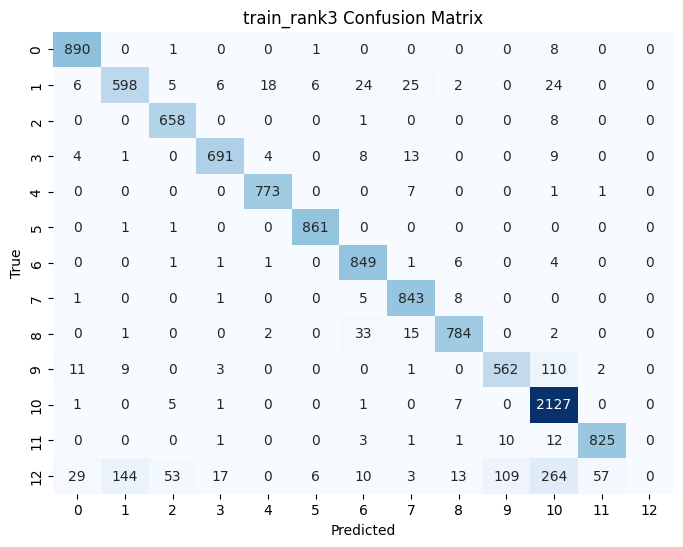

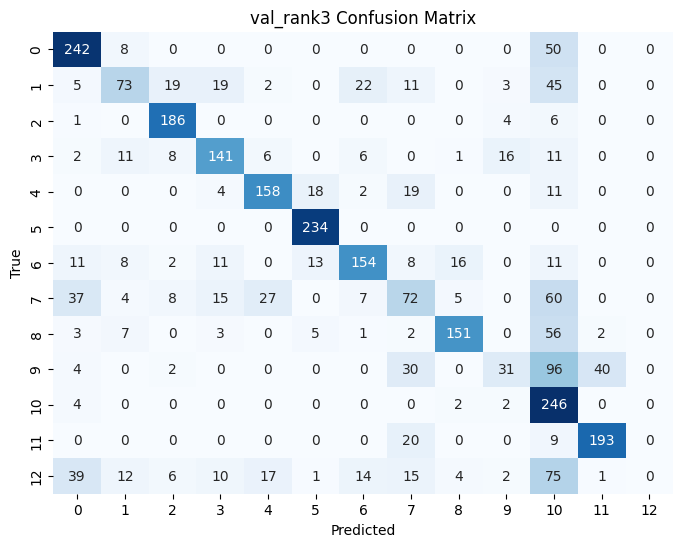

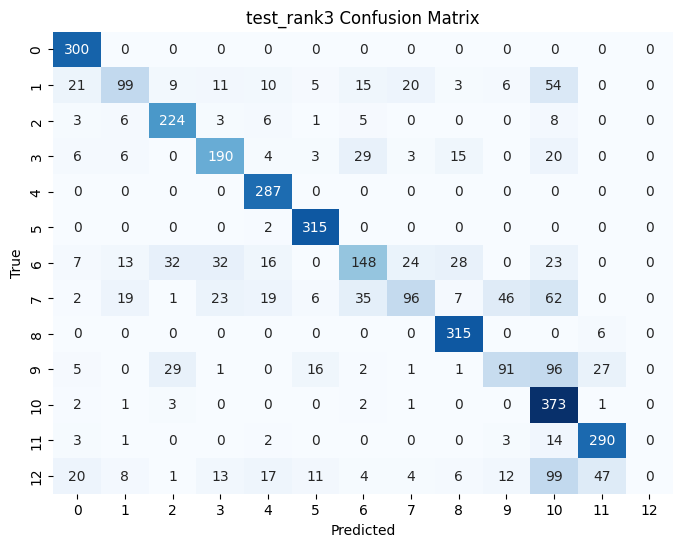

In [ ]:
# train
indices_correcto_train, indices_no_correcto_train = calcular_porcion_correcta(etiqueta_vector_train, predicciones_rank3_unica_train, 'train_rank3')

# val
indices_correcto_val, indices_no_correcto_val = calcular_porcion_correcta(etiqueta_vector_val, predicciones_rank3_unica_val, 'val_rank3')

# test
indices_correcto_test, indices_no_correcto_test = calcular_porcion_correcta(etiqueta_vector_test, predicciones_rank3_unica_test, 'test_rank3')

accuracy_train_rank3 = len(indices_correcto_train)/len(etiqueta_vector_train)
accuracy_val_rank3 = len(indices_correcto_val)/len(etiqueta_vector_val)
accuracy_test_rank3 = len(indices_correcto_test)/len(etiqueta_vector_test)

print(accuracy_train_rank3, accuracy_val_rank3, accuracy_test_rank3)

# Guardar experimento en Comet

In [ ]:
# Guardar resumen en una cadena de texto para guardarlo en Comet
stream = io.StringIO()
model.summary(print_fn=lambda x: stream.write(x + '\n'))
summary_str = stream.getvalue()
stream.close()

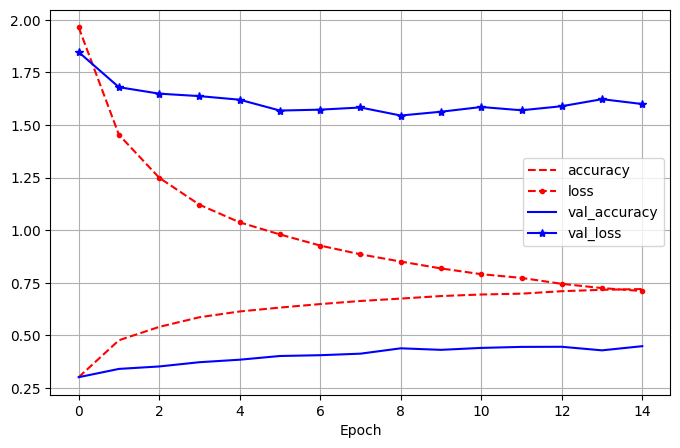

In [ ]:
nombre = nombre_exp
joblib.dump(model, nombre + '.pkl')
pd.DataFrame(complete_history).plot(
figsize=(8, 5), grid=True, xlabel="Epoch",  # xlim=[0, 10], ylim=[0, 1],
style=["r--", "r--.", "b-", "b-*"])
plt.savefig("evolucion_entrenamiento.png")

In [ ]:
API_KEY = 'ehXeElNypcj7Knar5zTmyjwSO'

exp = Experiment(api_key=API_KEY,
              project_name='tesis-experimentos', # Nombre del proyecto donde se registran los experimentos
              auto_param_logging=False)
exp.set_name(nombre) # Nombre de este experimento
exp.add_tags(['ronda3','features', 'con_reposo', '12_gestos','seq_seq', 'x_sujeto']) # Tags,'particion_1'

exp.log_metric("test_accuracy_rank1", accuracy_test_rank1)
exp.log_metric("val_accuracy_rank1", accuracy_val_rank1)
exp.log_metric("train_accuracy_rank1", accuracy_train_rank1)
exp.log_metric("test_accuracy_rank2", accuracy_test_rank2)
exp.log_metric("val_accuracy_rank2", accuracy_val_rank2)
exp.log_metric("train_accuracy_rank2", accuracy_train_rank2)
exp.log_metric("test_accuracy_rank3", accuracy_test_rank3)
exp.log_metric("val_accuracy_rank3", accuracy_val_rank3)
exp.log_metric("train_accuracy_rank3", accuracy_train_rank3)


exp.log_parameter("batch_size", BATCH_SIZE)
exp.log_parameter("stride", 1)
exp.log_parameter("largo_secuencia", 61)
exp.log_parameter("stop_epoch", 5)
exp.log_parameter("sample_weight", 0)
exp.log_parameter("porcentaje_label", 100)
exp.log_parameter("cantidad_gestos", 12)
exp.log_parameter("particion_datos", 1)
exp.log_parameter("lr", format(lr, ".8g"))

# Guardar la imagen en Comet
exp.log_image("evolucion_entrenamiento.png")

exp.log_image('train_rank1_matrix.png')
exp.log_image('val_rank1_matrix.png')
exp.log_image('test_rank1_matrix.png')

exp.log_image('train_rank2_matrix.png')
exp.log_image('val_rank2_matrix.png')
exp.log_image('test_rank2_matrix.png')

exp.log_image('train_rank3_matrix.png')
exp.log_image('val_rank3_matrix.png')
exp.log_image('test_rank3_matrix.png')

exp.log_text("Seq to seq, features, por sujeto, con reposo.\n")   # Comentario del experimento
exp.log_text("Model Summary:\n" + summary_str)
exp.log_model(name=nombre, file_or_folder=nombre + '.pkl')
exp.end()

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: tensorflow, sklearn, keras.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/manuelmolinach99/tesis-experimentos/ff44ebaadd2448899f20856d76e2ea12

COMET INFO: The process of logging environment details (conda environment, git patch) is underway. Please be patient as this may take some time.
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     name                  : ronda3_RNN_E1_feature_sin_reposo_100%_61_stride1_x_sujeto_seq_seq
COMET INFO: